In [2]:
!pip install problog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 941 kB 7.8 MB/s 
  Created wheel for problog: filename=problog-2.2.2-py3-none-any.whl size=1220796 sha256=55343a4c4f72ad843e5c665dbe651609f65896485eef53cba454733742c6efb1
  Stored in directory: /root/.cache/pip/wheels/40/91/9e/412180b9c1c11f560feb467dbb0455d15877ec35abbd2228e5
Successfully built problog


In [3]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
#from transformers import Trainer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from problog.program import PrologString
from problog import get_evaluatable
from datetime import datetime
from problog.program import PrologString
from problog import get_evaluatable
import math
import random
import re
import matplotlib.pyplot as plt
import time

# import datasets
# from datasets import Dataset, load_metric

import warnings
warnings.filterwarnings('ignore')

In [5]:
dt = {'album_favorites': 'Int64', 'album_title': 'category', 
 'artist_favorites': 'Int64', 'artist_name': 'category', 'track_favorites':'Int64', 'track_genre_top': 'category',
 'track_genres': 'object', 'track_genres_all':'object', 'track_interest':'Int64', 'track_listens': 'Int64',
 'track_title': 'object' }
csv_path = '/content/drive/My Drive/cs267a/data.csv'
all_data = pd.read_csv(csv_path, dtype= dt)

print(all_data.dtypes)


album_favorites        Int64
album_title         category
artist_favorites       Int64
artist_name         category
track_favorites        Int64
track_genre_top     category
track_genres          object
track_genres_all      object
track_interest         Int64
track_listens          Int64
track_title           object
dtype: object


In [6]:
# all_data = all_data.drop(all_data[all_data['track_title'].isna()].index)
# all_data = all_data.drop(all_data[all_data['artist_name'].isna()].index)
all_data = all_data.drop(all_data[all_data['album_title'].isna()].index)
all_data = all_data.drop(all_data[all_data['artist_favorites'] == -1].index)
all_data = all_data.drop(all_data[all_data['album_favorites'] == -1].index)
print(f"dataset size: {len(all_data)}")

dataset size: 9783


In [7]:
#data_frame = all_data[:2000]
data_frame = all_data[:30]
print(f"dataset size: {len(data_frame)}")

dataset size: 30


In [8]:
def get_level(q75, q50, q25, val): 
    if val >= q75: return 4
    if val >= q50: return 3
    if val >= q25: return 2
    return 1

def convert_to_level(data_frame):
  #split the numerical value into 4 levels.
  album_fav_q75 = data_frame['album_favorites'].quantile(0.75)
  album_fav_q50 = data_frame['album_favorites'].quantile(0.50)
  album_fav_q25 = data_frame['album_favorites'].quantile(0.25)
  data_frame['album_favorites_level'] = data_frame.apply(lambda row: get_level(album_fav_q75,album_fav_q50,album_fav_q25, row['album_favorites']), axis = 1)

  artist_fav_q75 = data_frame['artist_favorites'].quantile(0.75)
  artist_fav_q50 = data_frame['artist_favorites'].quantile(0.50)
  artist_fav_q25 = data_frame['artist_favorites'].quantile(0.25)
  data_frame['artist_favorites_level'] = data_frame.apply(lambda row: get_level(artist_fav_q75,artist_fav_q50,artist_fav_q25, row['artist_favorites']), axis = 1)

  track_int_q75 = data_frame['track_interest'].quantile(0.75)
  track_int_q50 = data_frame['track_interest'].quantile(0.50)
  track_int_q25 = data_frame['track_interest'].quantile(0.25)
  data_frame['track_interest_level'] = data_frame.apply(lambda row: get_level(track_int_q75,track_int_q50,track_int_q25, row['track_interest']), axis = 1)

  track_lis_q75 = data_frame['track_listens'].quantile(0.75)
  track_lis_q50 = data_frame['track_listens'].quantile(0.50)
  track_lis_q25 = data_frame['track_listens'].quantile(0.25)
  data_frame['track_listens_level'] = data_frame.apply(lambda row: get_level(track_lis_q75,track_lis_q50,track_lis_q25, row['track_listens']), axis = 1)


  track_fav_q75 = data_frame['track_favorites'].quantile(0.75)
  track_fav_q50 = data_frame['track_favorites'].quantile(0.50)
  track_fav_q25 = data_frame['track_favorites'].quantile(0.25)
  data_frame['track_favorites_level'] = data_frame.apply(lambda row: get_level(track_fav_q75,track_fav_q50,track_fav_q25, row['track_favorites']), axis = 1)


  #normalziation 
  data_frame['album_favorites_level'] = MinMaxScaler().fit_transform(np.array(data_frame['album_favorites_level']).reshape(-1,1))
  data_frame['artist_favorites_level'] = MinMaxScaler().fit_transform(np.array(data_frame['artist_favorites_level']).reshape(-1,1))
  data_frame['track_interest_level'] = MinMaxScaler().fit_transform(np.array(data_frame['track_interest_level']).reshape(-1,1))
  data_frame['track_listens_level'] = MinMaxScaler().fit_transform(np.array(data_frame['track_listens_level']).reshape(-1,1))
  data_frame['track_favorites_level'] = MinMaxScaler().fit_transform(np.array(data_frame['track_favorites_level']).reshape(-1,1))
  return data_frame

In [9]:
convert_to_level(data_frame)
print(data_frame)


    album_favorites            album_title  artist_favorites  \
0                 4   AWOL - A Way Of Life                 9   
1                 4   AWOL - A Way Of Life                 9   
2                 4   AWOL - A Way Of Life                 9   
3                 4      Constant Hitmaker                74   
4                 2                  Niris                10   
5                 2                  Niris                10   
6                 2                  Niris                10   
7                 2                  Niris                10   
8                 2                  Niris                10   
9                 4   AWOL - A Way Of Life                 9   
10                0                    mp3                 0   
11                0                    mp3                 0   
12                2           Live at LACE                 5   
13                2           Live at LACE                 5   
14                1  Every Man For Himse

In [21]:
# data_frame['album_favorites_normalized'] = MinMaxScaler().fit_transform(np.array(data_frame['album_favorites']).reshape(-1,1))
# data_frame['artist_favorites_normalized'] = MinMaxScaler().fit_transform(np.array(data_frame['artist_favorites']).reshape(-1,1))

# data_frame['track_favorites_normalized'] = MinMaxScaler().fit_transform(np.array(data_frame['track_favorites']).reshape(-1,1))
# data_frame['track_interest_normalized'] = MinMaxScaler().fit_transform(np.array(data_frame['track_interest']).reshape(-1,1))
# data_frame['track_listens_normalized'] = MinMaxScaler().fit_transform(np.array(data_frame['track_listens']).reshape(-1,1))
# data_frame['quality'] = data_frame['track_favorites_normalized'] / data_frame['track_listens_normalized']
# data_frame['quality'] = MinMaxScaler().fit_transform(np.array(data_frame['quality']).reshape(-1,1))
# example = data_frame[['track_favorites','quality']].head(20)
# print(example)

In [22]:
# w_fav = 0.5
# w_int = 0.2
# w_lis = 0.3


#data_frame['popularity'] = data_frame['track_favorites_normalized']*w_fav + data_frame['track_interest_normalized'] * w_int + data_frame['track_listens_normalized'] * w_lis
# sub_frame = data_frame[data_frame['album_title'] == 'AWOL - A Way Of Life']

# sub_frame = data_frame[:10]

# sub_frame_1 = sub_frame[['artist_favorites', 'album_favorites', 'track_favorites', 'track_interest', 'track_listens','popularity' ]]
#print(sub_frame_1)

# sub_frame_2 = sub_frame[['artist_favorites_normalized','album_favorites_normalized', 'track_favorites_normalized', 'track_interest_normalized', 'track_listens_normalized','popularity' ]]
# print(sub_frame_2)

# sub_frame_2 = sub_frame[['artist_favorites_normalized','album_favorites_normalized', 'track_favorites_normalized', 'track_interest_normalized', 'track_listens_normalized','popularity' ]]
# print(sub_frame_2)

# sub_frame_3 = sub_frame[['t_int_bin', 't_lis_bin', 't_fav_bin']]
# print(sub_frame_3)

In [23]:
# prob_str =""
# evidence_str = ""
# for index, row in data_frame.iterrows():
    
#     # prob_str = str(row['track_interest_normalized'])+f"::song_i({index}). \n"
#     evi_str = f"evidence(song_i, {row['track_interest_level']}).\n"
#     evi_str += f"evidence(song_l, {row['track_listens_level']}).\n"
#     evi_str += f"evidence(song_f, {row['track_favorites_level']}).\n"
#     evi_str += "-----\n"
#     evidence_str += evi_str


# rule = "t(_)::song_i.\n t(_)::song_l:-song_i. \n t(_)::song_f:-song_l."
# prob_str += rule

# text_file = open("fact_and_rule.pl", "w")
# n = text_file.write(prob_str)
# text_file.close()

# text_file = open("evidence.pl", "w")
# n = text_file.write(evidence_str)
# text_file.close()

# Model Generator

In [24]:
prob_str =""
evidence_str = ""
rule_str = ""
fact_str = ""

albums = []
artists = []
genres = []
song_to_favorites = {}

pattern = re.compile('[^a-zA-Z]+')

for index, row in data_frame.iterrows():
    # define albums
    album = "a"+pattern.sub('', str(row['album_title'])).lower()
    if not album in albums:
        albums.append(album)
        prob_str += f"t(_)::influence_via_album({album}). \n"
        fact_str+= f"album({album}). \n"
    # define artists
    artist = "a"+pattern.sub('', str(row['artist_name'])).lower()
    if not artist in artists:
        prob_str+= f"t(_)::influence_via_artist({artist}). \n"
        fact_str+= f"artist({artist}). \n"
        artists.append(artist)
    # define genres
    genre = "g"+pattern.sub('', str(row['track_genre_top'])).lower()
    if not genre in genres:
        prob_str+= f"t(_)::influence_via_genre({genre}). \n"
        fact_str+= f"genre({genre}). \n"
        genres.append(genre)
    # define songs
    song = "s"+pattern.sub('', str(row['track_title'])).lower()
    favorites = row['track_favorites_level']
    if not (favorites >= 0.0 and favorites <= 1.0):
        raise ValueError(f"invalid favorites {favorites}")
    if song not in song_to_favorites:
        song_to_favorites[song] = favorites
        prob_str+= f"t(_)::song_quality({song}). \n"
        fact_str+= f"song({song}). \n"

    fact_str+= f"belongs_to_album({song},{album}). \n"
    fact_str+= f"belongs_to_genre({song},{genre}). \n"
    fact_str+= f"belongs_to_artist({song},{artist}). \n"

    evidence_str += f"evidence(song_popularity({song}), {favorites}). \n"


rule1 = """
t(_)::song_popularity(S1):-song(S1), song_quality(S1).
"""

rule2 = """
song_popularity(X1):- 
    song(X1),
    song(X2),
    album(A),
    belongs_to_album(X1,A), 
    belongs_to_album(X2,A),
    influence_via_album(A), 
    song_popularity(X2).
"""

rule3 = """
song_popularity(X1):- 
    song(X1),
    song(X2),
    genre(G),
    belongs_to_genre(X1,G), 
    belongs_to_genre(X2,G),
    influence_via_genre(G), 
    song_popularity(X2).
"""

rule4 = """
song_popularity(X1):- 
    song(X1),
    song(X2),
    artist(A),
    belongs_to_artist(X1,A), 
    belongs_to_artist(X2,A),
    influence_via_artist(A), 
    song_popularity(X2).
"""
rules = [rule1, rule3, rule4]
rule_str = "\n".join(rules)

text_file = open("fact_and_rule.pl", "w")
#text_file.write("% facts\n")
text_file.write(fact_str+"\n")
#text_file.write("% probabilities\n")
text_file.write(prob_str+"\n")
#text_file.write("% rules\n")
text_file.write(rule_str+"")
text_file.close()

text_file = open("evidence.pl", "w")
n = text_file.write(evidence_str)
text_file.close()

#problog lfi .\fact_and_rule.pl .\evidence.pl -O .\output.pl

In [25]:
start_time = datetime.now()
!problog lfi fact_and_rule.pl evidence.pl -O output.pl
end_time = datetime.now()
print(f"\n Model generated in {end_time-start_time}")

tcmalloc: large alloc 1152008192 bytes == 0x37ae000 @  0x7f862422a887 0x424c9f 0x40bb4e 0x402a56 0x42695d 0x7f86234e6c18 0x402acd
-41.19111124162137 [0.3395013, 0.35815425, 0.08540434, 0.33208336, 0.132035, 0.29215679, 0.52779029, 0.67968595, 0.89121386, 0.44658683, 0.43645167, 0.27984939, 0.67062843, 0.46707471, 0.80938762, 0.4098924, 0.60049647, 0.85171165, 0.5429661, 0.33725787, 0.67594127, 0.20840568, 0.16870144, 0.89617908, 0.38112107, 0.84316986, 0.39905772, 0.84188386, 0.49871919, 0.99507636, 0.0763056, 0.48178539, 0.45121869, 0.48086676, 0.15300648, 0.63489843, 0.88572463, 0.66947998, 0.26451749, 0.49142396, 0.22527929, 0.345972, 0.735935, 0.89229655, 0.58993246, 0.3695814, 0.50926167, 0.59617918, 0.7574933, 0.17878106, 0.5561427, 0.66698133, 0.03872413, 0.08868939, 0.5269403, 0.83490847, 0.4469987, 0.70771398, 0.37193569, 0.41662536, 0.61478841, 0.34204543, 0.70620616] [t(_)::influence_via_album(aawolawayoflife), t(_)::influence_via_artist(aawol), t(_)::influence_via_genre(ghi

In [26]:
model_file = open("output.pl", "r")
model = model_file.read()
model_file.close()

# model += "query(song_popularity(sfood)). \n"
# model += "query(song_popularity(selectricave)). \n"
model += "query(song_popularity(_)). \n"
# print(model)

start_time = datetime.now()
prediction = get_evaluatable().create_from(PrologString(model)).evaluate()
end_time = datetime.now()
print(prediction)
print(f"\n Inference time: {end_time-start_time}")

{song_popularity(sfreeway): 0.315382374053617, song_popularity(srepetitivemotionsickness): 0.6140118744607708, song_popularity(sgimmeabuckorilltouchyouboilermaker): 0.675324190079941, song_popularity(samoebiasis): 0.7159491522414425, song_popularity(swireup): 0.6074425990669695, song_popularity(spunjabiwaterygrave): 0.6554995992603236, song_popularity(sohio): 0.6438096155668656, song_popularity(squeenofthewires): 0.480910345845089, song_popularity(scandyass): 0.5817183188042805, song_popularity(sstreetmusic): 0.4977966357660868, song_popularity(sthisworld): 0.39382018945165626, song_popularity(selectricave): 0.327439503442132, song_popularity(sfood): 0.41037229719961144, song_popularity(sblackout): 0.6954502782411572, song_popularity(ssideb): 0.7807815447165964, song_popularity(ssidea): 0.8036215587050437, song_popularity(slisteningtothesunshineburnthegrass): 0.5435289563724909, song_popularity(soutsidethewindowbeesbuzzed): 0.6618726456721208, song_popularity(slightoflight): 0.86975950

In [10]:
def rmse(target, predication):
  diff = 0
  for key in predication:
    start = str(key).index("(")
    end = str(key).index(")")
    song = str(key)[start+1:end]
    #print(f"{song}: {predication[key]}, {target[song]}")
    diff += (predication[key]-target[song])**2
  return math.sqrt(diff/len(predication))

def mae(target, predication):
  diff = 0
  for key in predication:
    start = str(key).index("(")
    end = str(key).index(")")
    song = str(key)[start+1:end]
    #print(f"{song}: {predication[key]}, {target[song]}")
    diff += abs(predication[key]-target[song])
  return diff/len(predication)

In [28]:
def get_random_predictoin(predication):
  rand = prediction.copy()
  for key in rand:
    rand[key] = random.random()
  return rand

In [29]:
random.seed(1)
rand = get_random_predictoin(prediction)

print("rmse:")
print(f"Problog: {rmse(song_to_favorites, prediction)}")
print(f"Random: {rmse(song_to_favorites, rand)}")

print("\nmae:")
print(f"Problog: {mae(song_to_favorites, prediction)}")
print(f"Random: {mae(song_to_favorites, rand)}")

rmse:
Problog: 0.5043616819952983
Random: 0.4967599702237819

mae:
Problog: 0.4298407998456578
Random: 0.38624534369051594


In [11]:
def inference_on_random_model(size):
  data_frame = all_data[:size]
  print(f"dataset size: {len(data_frame)}")

  prob_str =""
  evidence_str = ""
  rule_str = ""
  fact_str = ""

  albums = []
  artists = []
  genres = []
  song_to_favorites = {}

  pattern = re.compile('[^a-zA-Z]+')

  for index, row in data_frame.iterrows():
      # define albums
      album = "a"+pattern.sub('', str(row['album_title'])).lower()
      if not album in albums:
          albums.append(album)
          prob_str += f"t(_)::influence_via_album({album}). \n"
          fact_str+= f"album({album}). \n"
      # define artists
      artist = "a"+pattern.sub('', str(row['artist_name'])).lower()
      if not artist in artists:
          prob_str+= f"t(_)::influence_via_artist({artist}). \n"
          fact_str+= f"artist({artist}). \n"
          artists.append(artist)
      # define genres
      genre = "g"+pattern.sub('', str(row['track_genre_top'])).lower()
      if not genre in genres:
          prob_str+= f"t(_)::influence_via_genre({genre}). \n"
          fact_str+= f"genre({genre}). \n"
          genres.append(genre)
      # define songs
      song = "s"+pattern.sub('', str(row['track_title'])).lower()
      favorites = random.random()
      if not (favorites >= 0.0 and favorites <= 1.0):
          raise ValueError(f"invalid favorites {favorites}")
      if song not in song_to_favorites:
          song_to_favorites[song] = favorites
          prob_str+= f"t(_)::song_quality({song}). \n"
          fact_str+= f"song({song}). \n"

      fact_str+= f"belongs_to_album({song},{album}). \n"
      fact_str+= f"belongs_to_genre({song},{genre}). \n"
      fact_str+= f"belongs_to_artist({song},{artist}). \n"

      evidence_str += f"evidence(song_popularity({song}), {favorites}). \n"


  rule1 = """
  t(_)::song_popularity(S1):-song(S1), song_quality(S1).
  """

  rule2 = """
  song_popularity(X1):- 
      song(X1),
      song(X2),
      album(A),
      belongs_to_album(X1,A), 
      belongs_to_album(X2,A),
      influence_via_album(A), 
      song_popularity(X2).
  """

  rule3 = """
  song_popularity(X1):- 
      song(X1),
      song(X2),
      genre(G),
      belongs_to_genre(X1,G), 
      belongs_to_genre(X2,G),
      influence_via_genre(G), 
      song_popularity(X2).
  """

  rule4 = """
  song_popularity(X1):- 
      song(X1),
      song(X2),
      artist(A),
      belongs_to_artist(X1,A), 
      belongs_to_artist(X2,A),
      influence_via_artist(A), 
      song_popularity(X2).
  """
  rules = [rule1, rule2, rule3]
  rule_str = "\n".join(rules)

  text_file = open("fact_and_rule.pl", "w")
  #text_file.write("% facts\n")
  text_file.write(fact_str+"\n")
  #text_file.write("% probabilities\n")
  text_file.write(prob_str+"\n")
  #text_file.write("% rules\n")
  text_file.write(rule_str+"")
  text_file.close()

  text_file = open("evidence.pl", "w")
  n = text_file.write(evidence_str)
  text_file.close()

  start_time = time.time()
  !problog lfi fact_and_rule.pl evidence.pl -O output.pl
  end_time = time.time()
  parameter_learning_time = end_time-start_time
  print(f"Model generated in {parameter_learning_time}")

  model_file = open("output.pl", "r")
  model = model_file.read()
  model_file.close()
  model += "query(song_popularity(_)). \n"

  start_time = time.time()
  prediction = get_evaluatable().create_from(PrologString(model)).evaluate()
  end_time = time.time()
  inference_time = end_time-start_time
  print(f"Inference time: {inference_time}")

  return parameter_learning_time, inference_time

  


In [ ]:
indices = []
parameter_learning_time = []
inference_time = []
for i in range(40, 50):
  t1, t2 = inference_on_random_model(i)
  indices.append(i)
  parameter_learning_time.append(t1)
  inference_time.append(t2)

print(indices)
print(parameter_learning_time)
print(inference_time)

plt.plot(indices, parameter_learning_time)
plt.xlabel('dataset size')
plt.ylabel('parameter learning time')
plt.show()
plt.plot(indices, inference_time)
plt.xlabel('dataset size')
plt.ylabel('inference time')
plt.show()

dataset size: 40
tcmalloc: large alloc 1152008192 bytes == 0x41e2000 @  0x7fdf28f23887 0x424c9f 0x40bb4e 0x402a56 0x42695d 0x7fdf281dfc18 0x402acd
-39.091153644807754 [0.64485795, 0.48373023, 0.48374187, 0.92666152, 0.4227599, 0.55488198, 0.43670075, 0.4857091, 0.96694123, 0.18752294, 0.33523994, 0.28520564, 0.50574473, 0.59473148, 0.80270093, 0.36667925, 0.35696802, 0.41070845, 0.96283895, 0.52512131, 0.17773431, 0.18691355, 0.63378357, 0.91368141, 0.99649569, 0.18941474, 0.61696925, 0.26812714, 0.55814456, 0.74212653, 0.59688985, 0.1733614, 0.28595645, 0.53570982, 0.94679794, 0.64921073, 0.41046807, 0.46335752, 0.46513406, 0.68723368, 0.75589646, 0.15214839, 0.81095505, 0.57890539, 0.50208025, 0.64807474, 0.21886023, 0.38430597, 0.27929762, 0.33559842, 0.28330807, 0.70070234, 0.30764599, 0.59930018, 0.21353125, 0.54927729, 0.43733482, 0.59349591, 0.47553267, 0.45589912, 0.54484202, 0.5444792, 0.51395566, 0.06335879, 0.37739952, 0.59929801] [t(_)::influence_via_album(aawolawayoflife),

# Results

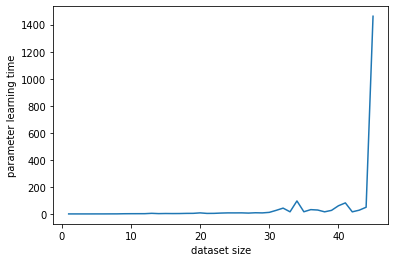

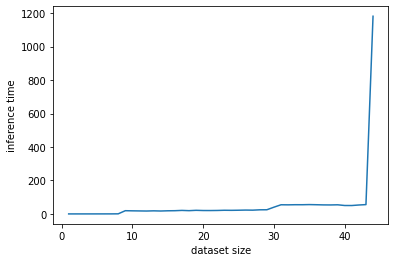

In [13]:
# rule2 + rule3
indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
           30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
parameter_learning_time = [0.21393632888793945, 0.21396207809448242, 0.2153024673461914, 0.21423673629760742, 0.31928253173828125, 
                           0.3152024745941162, 0.5134449005126953, 0.6180644035339355, 1.5187809467315674, 1.8208956718444824, 
                           1.9199976921081543, 2.024230480194092, 4.528769493103027, 2.423983097076416, 3.2293028831481934, 
                           2.825589179992676, 3.02547550201416, 4.126496315002441, 4.429190635681152, 7.883626937866211, 
                           3.9337875843048096, 4.327578067779541, 6.4313063621521, 7.838318347930908, 7.742924213409424,
                           8.040890455245972, 6.336061000823975, 8.75014615058899, 7.7424750328063965, 11.663806676864624, 
                           26.589163064956665, 43.066561222076416, 15.768728017807007, 96.12574243545532, 16.17621159553528, 
                           31.913857460021973, 29.00252056121826, 15.667762517929077, 26.489001989364624, 60.51851034164429, 
                           81.70936393737793, 15.577361583709717, 27.796868085861206, 49.59222340583801, 1461.981864452362]


inference_time = [0.029458045959472656, 0.0429072380065918, 0.07517766952514648, 0.10079789161682129, 0.13068175315856934, 
                  0.17235755920410156, 0.23371028900146484, 0.5404205322265625, 19.216037034988403, 18.494944095611572, 
                  17.886371612548828, 17.322494983673096, 18.441514253616333, 17.415427446365356, 18.727960348129272, 
                  19.230315446853638, 21.001096725463867, 19.469051599502563, 21.537201166152954, 20.331490755081177, 
                  20.198376178741455, 20.693817853927612, 21.8779354095459, 21.444778203964233, 22.110844135284424, 
                  22.98336911201477, 22.473341464996338, 24.55247187614441, 24.86344861984253, 40.27505826950073, 
                  54.71161341667175, 54.29702711105347, 55.00996017456055, 54.92138409614563, 55.76268815994263, 
                  54.933969259262085, 53.94945240020752, 53.6454963684082, 54.530317068099976, 50.308289766311646,
                  50.2001838684082, 53.33435606956482, 55.666502475738525, 1181.4993832111359]

plt.plot(indices+[45], parameter_learning_time)
plt.xlabel('dataset size')
plt.ylabel('parameter learning time')
plt.show()
plt.plot(indices, inference_time)
plt.xlabel('dataset size')
plt.ylabel('inference time')
plt.show()

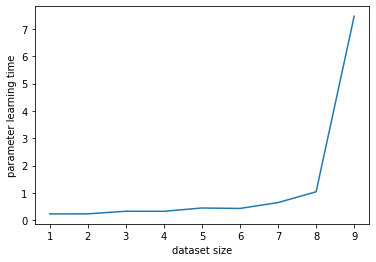

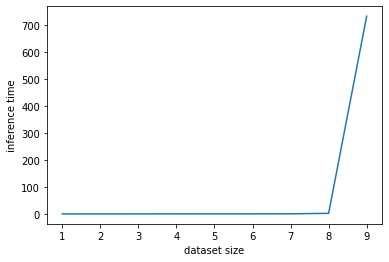

In [35]:
# all three rules
indices = [1, 2, 3, 4, 5, 6, 7, 8, 9]
parameter_learning_time = [0.2327585220336914, 0.2352461814880371, 0.3307619094848633, 0.32865452766418457, 0.44937920570373535, 
                           0.43291616439819336, 0.6476161479949951, 1.0414485931396484, 7.458491325378418]

inference_time = [0.045601606369018555, 0.06828641891479492, 0.14423632621765137, 0.25356245040893555, 0.2267148494720459, 
                  0.275313138961792, 0.37879037857055664, 2.2360646724700928, 731.5526964664459]

plt.plot(indices, parameter_learning_time)
plt.xlabel('dataset size')
plt.ylabel('parameter learning time')
plt.show()
plt.plot(indices, inference_time)
plt.xlabel('dataset size')
plt.ylabel('inference time')
plt.show()

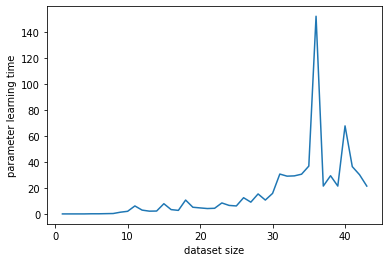

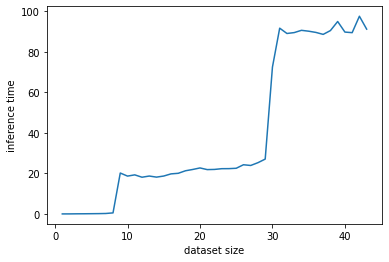

In [33]:
# without album rule
indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
           30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
parameter_learning_time = [0.21857643127441406, 0.22141480445861816, 0.2229933738708496, 0.22638630867004395, 0.32315993309020996, 
                           0.31990551948547363, 0.4216170310974121, 0.5203404426574707, 1.5354247093200684, 2.229588747024536, 
                           6.339900732040405, 3.136521816253662, 2.337252140045166, 2.4289000034332275, 8.056160926818848, 
                           3.5353376865386963, 2.928953170776367, 10.863177061080933, 5.3392791748046875, 4.833885431289673, 
                           4.3484790325164795, 4.543108224868774, 8.651081800460815, 6.74981427192688, 6.341802597045898, 
                           12.666597366333008, 9.254212379455566, 15.570098876953125, 10.86394476890564, 15.986953973770142, 
                           30.83943200111389, 29.229628324508667, 29.43751835823059, 30.7311532497406, 36.9561562538147, 
                           152.08158230781555, 21.610766172409058, 29.554089546203613, 21.603273630142212, 67.84720945358276,
                           36.54867720603943, 30.333775997161865, 21.602463006973267]
inference_time = [0.036385536193847656, 0.04721546173095703, 0.08933591842651367, 0.10819578170776367, 0.14257550239562988, 
                  0.1795811653137207, 0.24862933158874512, 0.5427627563476562, 20.210038900375366, 18.69439721107483, 
                  19.30550527572632, 18.14001727104187, 18.72327494621277, 18.1898295879364, 18.7257719039917, 
                  19.78724694252014, 20.074750423431396, 21.32493567466736, 21.964844465255737, 22.717869997024536, 
                  21.89807629585266, 21.98620843887329, 22.34943199157715, 22.377171754837036, 22.55602526664734, 
                  24.2936532497406, 23.939164876937866, 25.316279649734497, 27.082239151000977, 72.48653650283813, 
                  91.67673373222351, 89.05550789833069, 89.49022650718689, 90.61178517341614, 90.18286561965942, 
                  89.57519578933716, 88.61185956001282, 90.4893696308136, 94.96123003959656, 89.74681973457336,
                  89.46042513847351, 97.56016135215759, 91.19453072547913]

# inference on 44 never not terminates

plt.plot(indices, parameter_learning_time)
plt.xlabel('dataset size')
plt.ylabel('parameter learning time')
plt.show()
plt.plot(indices, inference_time)
plt.xlabel('dataset size')
plt.ylabel('inference time')
plt.show()